## Image Captioning
- Generating Caption for Images

## Steps
- Data Collection
- Understanding the Data
- Data Cleaning 
- Loading the TRaning Set
- Data Preprocessing -- Images
- Data Preprocessing -- Captions
- Data Preparation using Generator Function
- Words Ambeddings
- Model Architecture
- Inference
- Evaluation

In [2]:
# Importing all the liagries that we requirds min while

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras 
# import tensorflow as tf 
# from tensorflow import keras 
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from keras.models import Model, load_model
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers import add

In [2]:
# Read text Captions

def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
captions = readTextFile("./Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

In [4]:
 print(len(captions))

40460


In [5]:
first,second = captions[0].split('\t')
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [6]:
# Dictionary to Map each Image With the list of Captions it has

In [7]:
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if tje image id is already present or not 
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)
    

In [8]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

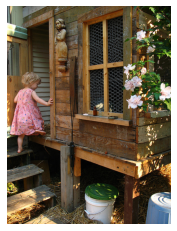

In [9]:
IMG_PATH = "Data/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

## Data Cleaning

In [10]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s) > 1]
    sentence = " ".join(sentence)
    return sentence


In [11]:
clean_text("A cat is sitting over the house number # 64")


'cat is sitting over the house number'

In [12]:
# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [13]:
# Write the data to text file
with open("descriptions_1.txt", "w") as f:
    f.write(str(descriptions))
    

## Vocabulary

In [14]:
discriptions = None
with open("descriptions_1.txt", 'r') as f:
    descriptions = f.read()

json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [15]:
print(type(descriptions))

<class 'dict'>


In [16]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("vocab Size : %d"% len(vocab))

vocab Size : 8424


In [17]:
# Total No of words across all the sentences 
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print("total words %d"%len(total_words))


total words 373837


In [18]:
# Filter words from the vocab according to certain threshold frequncy

In [19]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [20]:
# sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(), reverse = True, key = lambda x:x[1])

# Filter 
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1] > threshold]
total_words =  [x[0] for x in sorted_freq_cnt]

In [21]:
 print(len(total_words))

1845


## Prepare Train/Test Data

In [22]:
train_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [23]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [24]:
#print(train)

In [25]:
train[:5]    # 2513260012_03d33305cf.jpg

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [26]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training Data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append ="startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [27]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Transfer Learning
- Images --> Features
- Text --> Features

## Step - 1 Image Feature Extraction

In [28]:
model = ResNet50(weights = "imagenet", input_shape = (224, 224, 3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [29]:
model_new = Model(model.input, model.layers[-2].output)

In [30]:
def preprocess_img(img):
    img = image.load_img(img, target_size = (224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    # Normalisation
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


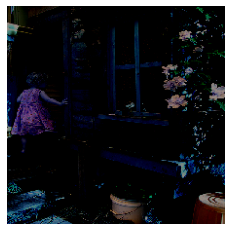

In [31]:
img = preprocess_img(IMG_PATH + "1000268201_693b08cb0e.jpg")
plt.imshow(img[0]/255.0)
plt.axis("off")
plt.show()

In [32]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [33]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

1/1 [==============================] - 3s 3s/step


array([0.06535926, 0.16782555, 0.3251761 , ..., 0.05107139, 0.32821193,
       1.0043361 ], dtype=float32)

In [37]:
start = time()
encoding_train = {}
# image_id --> feature_vector extracted from Resnet Image

for ix, img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix % 100 == 0:
        print("Encoding in Progress Time step %d"%ix) 
        
end_t = time()
print("Total Time Taken :", end_t-start)


1/1 [==============================] - 0s 162ms/step
Encoding in Progress Time step 0
1/1 [==============================] - 0s 156ms/step
Encoding in Progress Time step 100
1/1 [==============================] - 0s 159ms/step
Encoding in Progress Time step 200
1/1 [==============================] - 0s 167ms/step
Encoding in Progress Time step 300
1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 157ms/step
Encoding in Progress Time step 400
1/1 [==============================] - 0s 176ms/step


1/1 [==============================] - 0s 160ms/step
Encoding in Progress Time step 500
1/1 [==============================] - 0s 202ms/step
Encoding in Progress Time step 600
1/1 [==============================] - 0s 83ms/step
Encoding in Progress Time step 700
1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 90ms/step
Encoding in Progress Time step 800
1/1 [==============================] - 0s 119ms/step
Encoding in Progress Time step 900
1/1 [==============================] - 0s 137ms/step
Encoding in Progress Time step 1000
1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 72ms/step
Encoding in Progress Time step 1100
1/1 [==============================] - 0s 157ms/step
Encoding in Progress Time step 1200
1/1 [==============================] - 0s 81ms/step
Encoding in Progress Time step 1300
1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 166ms/step
Encoding in Progress Time step 1400
1/1 [==============================] - 0s 85ms/step
Encoding in Progress Time step 1500
1/1 [==============================] - 0s 77ms/step
Encoding in Progress Time step 1600
1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 171ms/step
Encoding in Progress Time step 1700
1/1 [==============================] - 0s 72ms/step
Encoding in Progress Time step 1800
1/1 [==============================] - 0s 158ms/step
Encoding in Progress Time step 1900
1/1 [==============================] - 0s 143ms/step
Encoding in Progress Time step 2000
1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 171ms/step
Encoding in Progress Time step 2100
1/1 [==============================] - 0s 175ms/step
Encoding in Progress Time step 2200
1/1 [==============================] - 0s 143ms/step
Encoding in Progress Time step 2300
1/1 [==============================] - 0s 103ms/step


1/1 [==============================] - 0s 156ms/step
Encoding in Progress Time step 2400
1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 101ms/step
Encoding in Progress Time step 2500
1/1 [==============================] - 0s 163ms/step
Encoding in Progress Time step 2600
1/1 [==============================] - 0s 107ms/step
Encoding in Progress Time step 2700
1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 82ms/step
Encoding in Progress Time step 2800
1/1 [==============================] - 0s 93ms/step
Encoding in Progress Time step 2900
1/1 [==============================] - 0s 162ms/step
Encoding in Progress Time step 3000
1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 154ms/step
Encoding in Progress Time step 3100
1/1 [==============================] - 0s 148ms/step
Encoding in Progress Time step 3200
1/1 [==============================] - 0s 84ms/step
Encoding in Progress Time step 3300
1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 173ms/step
Encoding in Progress Time step 3400
1/1 [==============================] - 0s 104ms/step
Encoding in Progress Time step 3500
1/1 [==============================] - 0s 100ms/step
Encoding in Progress Time step 3600
1/1 [==============================] - 0s 84ms/step
Encoding in Progress Time step 3700


1/1 [==============================] - 0s 166ms/step
Encoding in Progress Time step 3800
1/1 [==============================] - 0s 76ms/step
Encoding in Progress Time step 3900
1/1 [==============================] - 0s 92ms/step
Encoding in Progress Time step 4000
1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 99ms/step
Encoding in Progress Time step 4100
1/1 [==============================] - 0s 70ms/step
Encoding in Progress Time step 4200
1/1 [==============================] - 0s 89ms/step
Encoding in Progress Time step 4300
1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 169ms/step
Encoding in Progress Time step 4400
1/1 [==============================] - 0s 164ms/step
Encoding in Progress Time step 4500
1/1 [==============================] - 0s 158ms/step
Encoding in Progress Time step 4600
1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 169ms/step
Encoding in Progress Time step 4700
1/1 [==============================] - 0s 72ms/step
Encoding in Progress Time step 4800
1/1 [==============================] - 0s 72ms/step
Encoding in Progress Time step 4900
1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 83ms/step
Encoding in Progress Time step 5000
1/1 [==============================] - 0s 79ms/step
Encoding in Progress Time step 5100
1/1 [==============================] - 0s 73ms/step
Encoding in Progress Time step 5200
1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 80ms/step
Encoding in Progress Time step 5300
1/1 [==============================] - 0s 161ms/step
Encoding in Progress Time step 5400
1/1 [==============================] - 0s 81ms/step
Encoding in Progress Time step 5500
1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 108ms/step
Encoding in Progress Time step 5600
1/1 [==============================] - 0s 128ms/step
Encoding in Progress Time step 5700
1/1 [==============================] - 0s 65ms/step
Encoding in Progress Time step 5800
1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 74ms/step
Encoding in Progress Time step 5900
1/1 [==============================] - 0s 101ms/step
Total Time Taken : 1070.9171378612518


In [38]:
keys = encoding_train.keys()
print(type(keys))

<class 'dict_keys'>


In [39]:
# Store everything to the disk
with open("encoded_train_features.pkl", "wb") as f:
    pickle.dump(encoding_train, f)

In [40]:
start = time()
encoding_test = {}
# image_id --> feature_vector extracted from Resnet Image

for ix, img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix % 100 == 0:
        print("Test Encoding in Progress Time step %d"%ix)
        
end_t = time()
print("Total Time Taken(test) :", end_t-start)


1/1 [==============================] - 0s 67ms/step
Test Encoding in Progress Time step 0
1/1 [==============================] - 0s 164ms/step
Test Encoding in Progress Time step 100
1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 66ms/step
Test Encoding in Progress Time step 200
1/1 [==============================] - 0s 114ms/step
Test Encoding in Progress Time step 300
1/1 [==============================] - 0s 115ms/step
Test Encoding in Progress Time step 400
1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 91ms/step
Test Encoding in Progress Time step 500
1/1 [==============================] - 0s 90ms/step
Test Encoding in Progress Time step 600
1/1 [==============================] - 0s 115ms/step
Test Encoding in Progress Time step 700
1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 89ms/step
Test Encoding in Progress Time step 800
1/1 [==============================] - 0s 117ms/step
Test Encoding in Progress Time step 900
1/1 [==============================] - 0s 91ms/step
Total Time Taken(test) : 160.76189613342285


In [42]:
# Store everything to the disk
with open("encoded_test_features.pkl", "wb") as f:
    pickle.dump(encoding_test, f)

## Data Pre-processing for Captions

In [43]:
# Vocab
len(total_words)

1845

In [44]:
word_to_idx = {}
idx_to_word = {}

for i, word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [45]:
#word_to_idx["dog"]
#idx_to_word[1]
print(len(idx_to_word))

1845


In [46]:
# two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size", vocab_size)

Vocab Size 1848


In [47]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len, len(cap.split()))

print(max_len)

35


## Data Loader (Generator)

In [48]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size):
    x1, x2, y = [], [], []
    
    n = 0
    while True:
        for key, desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            #photo = str(photo)
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1, len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi], maxlen = max_len, value = 0, padding = 'post')[0]
                    yi = to_categorical([yi], num_classes = vocab_size)[0]
                    
                    x1.append(photo)
                    x2.append(xi)
                    y.append(yi)
                    
                if n == batch_size:
                    yield [[np.array(x1), np.array(x2)], np.array(y)]
                    
                    x1, x2, y = [], [], []
                    n = 0

## Word Embeddings

In [49]:
f = open("./saved/glove.6B.50d.txt", encoding = 'utf8')

In [50]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding =  np.array(values[1:], dtype = 'float')
    embedding_index[word] = word_embedding

In [51]:
f.close()

In [52]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [53]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size, emb_dim))
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

In [54]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [55]:
embedding_matrix[1847]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Model Architecture

In [56]:
input_img_features = Input(shape = (2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256, activation = 'relu')(inp_img1)

In [57]:
# Captions os Input
input_captions = Input(shape = (max_len,))
inp_cap1 = Embedding(input_dim = vocab_size, output_dim = 50, mask_zero = True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [58]:
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

# Combined Model
model = Model(inputs = [input_img_features, input_captions], outputs = outputs)

In [59]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [60]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [61]:
model.compile(loss = 'categorical_crossentropy', optimizer = "adam")

## Train Our Model

In [62]:
epochs = 10
number_pics_per_bath = 3
batch_size = 3
steps = len(train_descriptions)//number_pics_per_bath


In [64]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
    model.fit_generator(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)
    model.save('./model_weights/model_'+str(i)+'.h5')

C:\Users\HP\AppData\Local\Temp\ipykernel_4204\739603500.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)


2000/2000 [==============================] - 505s 253ms/step - loss: 2.7813


In [65]:
model = load_model('./model_weights/model_9.h5')

## Predictions

In [66]:
def predict_caption(photo):
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], max_len, padding = 'post')
        
        ypred = model.predict([photo, sequence])
        ypred = ypred.argmax() # word with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
            
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption
        

In [3]:
# Pick Some Random Images and See Results
for i in range(1):
    idx = np.random.randint(0, 1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1, 2048))
    
    i = plt.imread("Data/Images/" + img_name + ".jpg")
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    caption = predict_caption(photo_2048)
    print(caption)
    

NameError: name 'encoding_test' is not defined